# text classification

демонстрируется классификация текста, начиная с простых текстовых файлов, хранящихся на диске.

In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
print(tf.__version__)

2.3.0


Анализ настроений
Эта записная книжка обучает модель анализа настроений, чтобы классифицировать обзоры фильмов как положительные или отрицательные на основе текста обзора. Это пример двоичной - или двухклассовой - классификации, важной и широко применяемой задачи машинного обучения.

Вы будете использовать набор данных Large Movie Review , содержащий текст 50 000 обзоров фильмов из базы данных Internet Movie . Они разделены на 25 000 отзывов для обучения и 25 000 обзоров для тестирования. Наборы для обучения и тестирования сбалансированы , то есть содержат одинаковое количество положительных и отрицательных отзывов.

Загрузите и изучите набор данных IMDB
Давайте загрузим и извлечем набор данных, а затем исследуем структуру каталогов.



### Загрузите и изучите набор данных IMDB
Давайте загрузим и извлечем набор данных, а затем исследуем структуру каталогов.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 7s 0us/step


In [ ]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'test', 'train', 'README']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'urls_neg.txt',
 'urls_unsup.txt',
 'neg',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat',
 'unsup']

aclImdb/train/pos и aclImdb/train/neg содержат множество текстовых файлов, каждый из которых представляет собой отдельный обзор фильма. Давайте посмотрим на один из них.



In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Загрузите набор данных
Затем вы загрузите данные с диска и подготовите их в формате, подходящем для обучения. Для этого вы будете использовать полезную утилиту text_dataset_from_directory , которая ожидает следующую структуру каталогов.


```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

Чтобы подготовить набор данных для двоичной классификации, вам понадобятся две папки на диске, соответствующие class_a и class_b . Это будут положительные и отрицательные обзоры фильмов, которые можно найти в aclImdb/train/pos и aclImdb/train/neg . Поскольку набор данных IMDB содержит дополнительные папки, вы удалите их перед использованием этой утилиты.



In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Затем вы воспользуетесь утилитой text_dataset_from_directory для создания помеченного tf.data.Dataset . tf.data - это мощный набор инструментов для работы с данными.

При проведении эксперимента с машинным обучением рекомендуется разделить набор данных на три части: обучение , проверка и тестирование .

Набор данных IMDB уже разделен на обучающий и тестовый, но в нем отсутствует набор для проверки. Давайте создадим набор проверки, используя разделение обучающих данных 80:20, используя аргумент validation_split ниже.

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Как вы можете видеть выше, в папке обучения 25 000 примеров, из которых вы будете использовать 80% (или 20 000) для обучения. Как вы вскоре увидите, вы можете обучить модель, передав набор данных непосредственно в model.fit . Если вы новичок в tf.data , вы также можете tf.data набор данных и распечатать несколько примеров, как tf.data ниже.



In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Обратите внимание, что обзоры содержат необработанный текст (с пунктуацией и случайными HTML-тегами, например <br/> ). В следующем разделе вы покажете, как с ними справиться.

Метки равны 0 или 1. Чтобы увидеть, какие из них соответствуют положительным и отрицательным обзорам фильмов, вы можете проверить свойство class_names в наборе данных.



In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Затем вы создадите набор данных для проверки и тестирования. Вы будете использовать оставшиеся 5000 отзывов из обучающего набора для проверки.



In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Подготовьте набор данных для обучения
Затем вы стандартизируете, токенизируете и векторизуете данные с помощью полезного слоя preprocessing.TextVectorization .

Стандартизация относится к предварительной обработке текста, как правило, для удаления знаков пунктуации или элементов HTML для упрощения набора данных. Токенизация относится к разделению строк на токены (например, разделение предложения на отдельные слова путем разделения на пробелы). Векторизация относится к преобразованию токенов в числа, чтобы их можно было передать в нейронную сеть. Все эти задачи могут быть выполнены с помощью этого слоя.

Как вы видели выше, обзоры содержат различные HTML-теги, например <br /> . Эти теги не будут удалены стандартизатором по умолчанию в слое TextVectorization (который по умолчанию преобразует текст в нижний регистр и удаляет знаки пунктуации, но не удаляет HTML). Вы напишете специальную функцию стандартизации для удаления HTML.



In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Затем вы создадите слой TextVectorization . вы будете использовать этот слой для стандартизации, токенизации и векторизации наших данных. Вы устанавливаете output_mode в int чтобы создать уникальные целочисленные индексы для каждого токена.

Обратите внимание, что вы используете функцию разделения по умолчанию и пользовательскую функцию стандартизации, которую вы определили выше. Вы также определите некоторые константы для модели, например, явное максимальное значение sequence_length , которое заставит слой дополнять или обрезать последовательности до точных значений sequence_length .



In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Затем вы вызовете adapt чтобы подогнать состояние слоя предварительной обработки к набору данных. Это заставит модель построить индекс строк для целых чисел.



In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Как вы можете видеть выше, каждый токен был заменен целым числом. Вы можете найти токен (строку), которому соответствует каждое целое число, вызвав .get_vocabulary() на уровне.



In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


Вы почти готовы обучать свою модель. В качестве последнего шага предварительной обработки вы примените слой TextVectorization, который вы создали ранее, к набору данных для обучения, проверки и тестирования.



In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Настройте набор данных для повышения производительности
Это два важных метода, которые вы должны использовать при загрузке данных, чтобы убедиться, что ввод-вывод не становится блокирующим.

.cache() сохраняет данные в памяти после их загрузки с диска. Это гарантирует, что набор данных не станет узким местом при обучении вашей модели. Если ваш набор данных слишком велик для размещения в памяти, вы также можете использовать этот метод для создания производительного кеша на диске, который более эффективен для чтения, чем многие небольшие файлы.

.prefetch() перекрывает предварительную обработку данных и выполнение модели во время обучения.



In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Создайте модель
Пришло время создать нашу нейронную сеть:

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim,),
  #layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  #layers.Dropout(0.2),
  layers.Dense(145)
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Слои складываются последовательно для построения классификатора:

Первый слой - это слой Embedding . Этот уровень принимает обзоры в целочисленной кодировке и ищет вектор внедрения для каждого индекса слова. Эти векторы изучаются по мере обучения модели. Векторы добавляют измерение к выходному массиву. В результате получаются следующие размеры: (batch, sequence, embedding) . Чтобы узнать больше о встраивании, см. Руководство по встраиванию слов .
Затем слой GlobalAveragePooling1D возвращает выходной вектор фиксированной длины для каждого примера путем усреднения по измерению последовательности. Это позволяет модели обрабатывать ввод переменной длины самым простым способом.
Этот выходной вектор фиксированной длины проходит через полностью связанный ( Dense ) слой с 16 скрытыми блоками.
Последний слой плотно связан с единственным выходным узлом.


In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model


In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 10s 16ms/step - loss: 0.6649 - binary_accuracy: 0.6873 - val_loss: 0.6161 - val_binary_accuracy: 0.7718
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5504 - binary_accuracy: 0.7994 - val_loss: 0.4999 - val_binary_accuracy: 0.8192
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4466 - binary_accuracy: 0.8427 - val_loss: 0.4214 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3802 - binary_accuracy: 0.8655 - val_loss: 0.3748 - val_binary_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3362 - binary_accuracy: 0.8783 - val_loss: 0.3456 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3068 - binary_accuracy: 0.8881 - val_loss: 0.3265 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3104 - binary_accuracy: 0.8738
Loss:  0.3103800117969513
Accuracy:  0.8737999796867371


### Create a plot

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

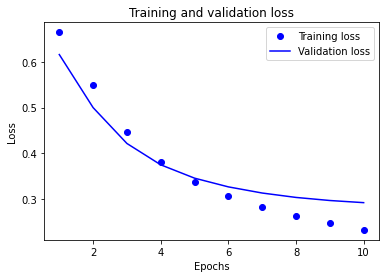

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

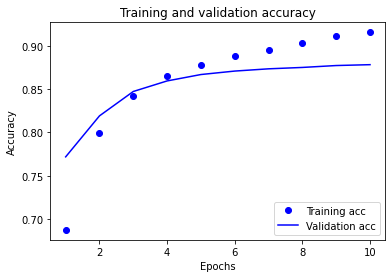

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3104 - accuracy: 0.8738
0.8737999796867371


In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6320554 ],
       [0.45298123],
       [0.3706004 ]], dtype=float32)